## Multivariate autoregressive model example

In this case study we analyze multivariate time series using generic linear stochastic dynamical systems models. 
We will use these models to analyze multispecies time series and extract information on time series interactions and forcing.

The model we will analyze is given as 

$$ \mathbf{x}(t+1) = \mathbf{\Phi} \mathbf{x}(t) + \mathbf{e}(t) $$

where $\mathbf{x}(t)$ is a multivariate time series at time $t$, $\mathbf{\Phi}$ is the linear dynamics matrix, and $\mathbf{e}(t)$ is a realization of a stochastic variable, assumed here multivariate normal with mean vector zero and covariance matrix, $\mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$.

In general, we can think of this model as a first order approximation to the dynamics of a more general multivariate dynamical system. 
In this context, the matrix $\mathbf{\Phi}$ would represent the Jacobian matrix, containing information on the discretized partial derivatives of each state variable with respect to each of the others. 
The matrix $\mathbf{\Sigma}$ contains information on the magnitude of stochastic forcing as well as correlations among the variables responses.

To explore this model we will first simulate some data

In [3]:
library(MASS)     #package for the multi-variate normal distribution
library(rstan)
options(mc.cores = parallel::detectCores())

The procedure below uses some linear algebra (specifically the $QR$ decomposition) to generate a random matrix that will stable, i.e. that simulated time series won't blow-up.
We do so by making the eigenvalues of the random matrix lie between 0 and 1.

In [19]:
p     <- 3

SIGMA  <- diag(runif(p))   #generate random numbers

eig    <- runif(p,0,1)
Z      <- matrix(ncol=p, rnorm(p^2))
decomp <- qr(Z)
Q      <- qr.Q(decomp)
R      <- qr.R(decomp)
d      <- diag(R)
ph     <- d / abs(d)
O      <- Q %*% diag(ph)
PHI    <- t(O) %*% diag(eig) %*% O

We simulate time series given the specified parameters. 
Notice we are drawing a multivariate normal realization every time step with mean zero and covariance matrix `SIGMA`.

In [20]:
T  <- 200
y0 <- rnorm(p)
Y     <- matrix(NA,p,T)
Y[,1] <- y0

for(t in 2:T){
    Y[,t] <- PHI%*%Y[,t-1] + mvrnorm(1,rep(0,3),SIGMA)}

Plot the system

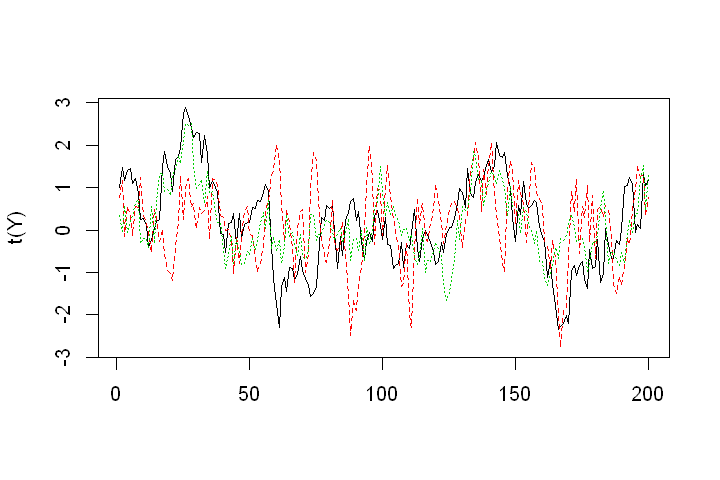

In [21]:
options(repr.plot.width=6, repr.plot.height=4)
matplot(t(Y),type='l')

The Stan code below implements the first order multivariate model.
As per usual, we pass Stan the data and its dimensions in the `data` block.
In the `parameters` block, we define the linear dynamics matrix `PHI` which has as many rows and columns as there are time series.
In this case we assume the covariance matrix is of the form

$$ \mathbf{\Sigma} = \begin{bmatrix} \sigma_{1,1} & 0 & \cdots & 0\\
                                    0 & \sigma_{2,2} & \ddots & \vdots \\
                                    \vdots & \ddots & \ddots & \vdots \\
                                    0 & \cdots & \cdots & \sigma_{p,p} \end{bmatrix}   $$
                                    
which means that each species in the mulispecies time series responds to the environment independently.

In [11]:
mod_code <- "data {
	int T;         //length of time series
	int p;         //number of variables
	matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
	matrix[p,p] PHI;     //dynamics matrix
	vector<lower=1E-15>[p] sigma;     //variances of stochastic forcing
	vector[p] init;      //mean of initial conditions as parameter vector
}
model{
	Y[,1] ~ normal(init, sigma);           //distribution of the initial conditions
	for(i in 2:T){
		Y[,i] ~ normal(PHI*Y[,i-1],sigma); //conditional predictive distribution
	}
}"

Compile the model

In [12]:
mod <- stan_model(model_code=mod_code)

Organize the data for Stan

In [13]:
data <- list(p=p,T=T,Y=Y)

Perform mcmc

In [9]:
mcmc <- sampling(mod,data=data,iter=2000,warmup=1000,open_progress=TRUE)

In [10]:
mcmc

Inference for Stan model: f6a593bd1d150b083482aed6d79f4a99.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
PHI[1,1]   0.14    0.00 0.07   0.01   0.10   0.14   0.19   0.28  5709    1
PHI[1,2]  -0.34    0.00 0.08  -0.50  -0.39  -0.34  -0.29  -0.19  4913    1
PHI[1,3]   0.01    0.00 0.01  -0.01   0.00   0.01   0.01   0.02  6423    1
PHI[2,1]  -0.27    0.00 0.01  -0.28  -0.27  -0.27  -0.26  -0.25  7750    1
PHI[2,2]   0.58    0.00 0.01   0.57   0.58   0.58   0.59   0.60  7820    1
PHI[2,3]   0.01    0.00 0.00   0.01   0.01   0.01   0.01   0.02  4400    1
PHI[3,1]  -0.34    0.01 0.45  -1.23  -0.64  -0.33  -0.03   0.55  6652    1
PHI[3,2]  -0.33    0.01 0.48  -1.27  -0.65  -0.33   0.00   0.61  5256    1
PHI[3,3]   0.75    0.00 0.05   0.65   0.71   0.74   0.78   0.85  6961    1
sigma[1]   0.13    0.00 0.01   0.12   0.12   0.13   0.13   0.14  7149   

### Investigating the stochastic forcing matrix
Here we relax the assumption of independent forcing and specify a covariance matrix with non zero off diagonal elements

$$ \mathbf{\Sigma} = \begin{bmatrix} \sigma_{1,1} & \sigma_{1,2} & \cdots & \sigma_{1,p}\\
                                    \sigma_{2,1} & \sigma_{2,2} & \ddots & \vdots \\
                                    \vdots & \ddots & \ddots & \vdots \\
                                    \sigma_{p,1} & \cdots & \cdots & \sigma_{p,p} \end{bmatrix}   $$

Generate a random matrix that is a proper covariance matrix, i.e. it is positive semi-definite

In [24]:
A      <- matrix(runif(p^2)*2-1, ncol=p)   #generate random numbers
SIGMA2 <- t(A) %*% A   
SIGMA2

0.63758310,-0.6911165,-0.02680164
-0.69111654,1.2422077,-0.13816009
-0.02680164,-0.1381601,0.89284807


Simulate synthetic time series with the covariance matrix above

In [25]:
T      <- 200
y20    <- rnorm(p)
Y2     <- matrix(NA,p,T)
Y2[,1] <- y20

for(t in 2:T){
    Y2[,t] <- PHI%*%Y2[,t-1] + mvrnorm(1,rep(0,3),SIGMA2)}

Plot the time series

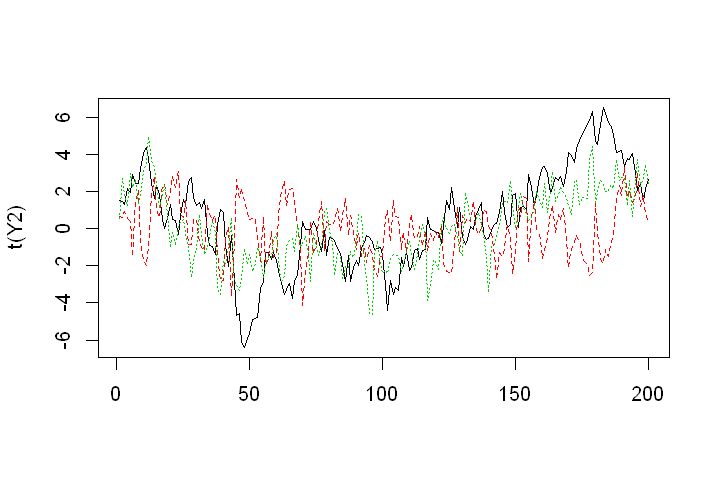

In [27]:
options(repr.plot.width=6, repr.plot.height=4)
matplot(t(Y2),type='l')

Package the data

In [28]:
data2 <- list(p=p,T=T,Y=Y2)

We estimate the full covariance in the Stan code below.
We make use of the very handy parameter type `cov_matrix` which maintains the positive semi-definite requirement throughout the mcmc iterations.

In [29]:
mod_code_cov <- "data {
	int T;         //length of time series
	int p;         //number of variables
	matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
	matrix[p,p] PHI;     //dynamics matrix
	cov_matrix[p] SIGMA; //co-variance matrix of stochastic forcing
	vector[p] init;      //mean of initial conditions as parameter vector
}
model{
	Y[,1] ~ multi_normal(init, SIGMA);           //distribution of the initial conditions
	for(i in 2:T){
		Y[,i] ~ multi_normal(PHI*Y[,i-1],SIGMA); //conditional predictive distribution
	}
}"

Compile the model

In [30]:
mod_cov <- stan_model(model_code=mod_code_cov)

Perform mcmc

In [31]:
mcmc_cov <- sampling(mod_cov,data=data2,chains=4,open_progress=TRUE)

In [32]:
mcmc_cov

Inference for Stan model: e6d8967789fad31353e0995a8fbf8293.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
PHI[1,1]      0.89    0.00 0.03    0.83    0.87    0.89    0.92    0.95  2320
PHI[1,2]      0.08    0.00 0.04   -0.01    0.05    0.08    0.11    0.16  2867
PHI[1,3]      0.14    0.00 0.04    0.05    0.11    0.13    0.17    0.22  2195
PHI[2,1]      0.02    0.00 0.05   -0.08   -0.02    0.01    0.05    0.11  2121
PHI[2,2]      0.59    0.00 0.06    0.46    0.54    0.59    0.63    0.71  2796
PHI[2,3]      0.04    0.00 0.06   -0.09   -0.01    0.04    0.08    0.16  2197
PHI[3,1]      0.21    0.00 0.04    0.12    0.18    0.21    0.23    0.29  2735
PHI[3,2]      0.15    0.00 0.06    0.04    0.11    0.15    0.19    0.26  3993
PHI[3,3]      0.62    0.00 0.06    0.52    0.59    0.62    0.66    0.74  2817
SIGMA[1,1]    0.65    0.00 0.07    0.53   

### Incorporating informative priors on the structure of the dynamics

Here we will impose informative priors on particular elements of the $\mathbf{\Phi}$

The Stan code below imposes the following structure on $\mathbf{\Phi}$:

$$ \mathbf{\Phi} = \begin{bmatrix} \phi_{1,1} & \phi_{1,2} & 0 \\ 
                                \phi_{2,1} & \phi_{2,2} & \phi_{2,3}\\
                                0       & \phi_{3,2} & \phi_{3,3} \end{bmatrix} $$

In [11]:
mod_code_D_struc <- "data {
	int T;         //length of time series
	int p;         //number of variables
	matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
	matrix[p,p] PHI;               //dynamics matrix
	vector<lower=1E-15>[p] sigma;  //variances of stochastic forcing
	vector[p] init;                //mean of initial conditions as parameter vector
}
model{
    PHI[1,3] ~ normal(0,1E-3);
    PHI[3,1] ~ normal(0,1E-3);

	Y[,1] ~ normal(init, sigma);           //distribution of the initial conditions
	for(i in 2:T){
		Y[,i] ~ normal(PHI*Y[,i-1],sigma); //conditional predictive distribution
	}
}"

In [12]:
mod_struc <- stan_model(model_code=mod_code_D_struc)

In [13]:
mcmc_struc <- sampling(mod_struc,data=data,chains=4,open_progress=TRUE)

In [14]:
mcmc_struc

Inference for Stan model: 4244507c4c9e43c3755b1db25ce9f318.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
PHI[1,1]   0.15    0.00 0.07   0.01   0.10   0.15   0.20   0.29  5476    1
PHI[1,2]  -0.33    0.00 0.07  -0.47  -0.38  -0.32  -0.28  -0.18  5059    1
PHI[1,3]   0.00    0.00 0.00   0.00   0.00   0.00   0.00   0.00  3702    1
PHI[2,1]  -0.27    0.00 0.01  -0.28  -0.27  -0.27  -0.26  -0.25  5902    1
PHI[2,2]   0.58    0.00 0.01   0.57   0.58   0.58   0.59   0.60  5833    1
PHI[2,3]   0.01    0.00 0.00   0.01   0.01   0.01   0.01   0.02  3814    1
PHI[3,1]   0.00    0.00 0.00   0.00   0.00   0.00   0.00   0.00  4060    1
PHI[3,2]  -0.21    0.01 0.45  -1.08  -0.52  -0.21   0.09   0.66  5205    1
PHI[3,3]   0.74    0.00 0.05   0.64   0.71   0.74   0.78   0.85  6645    1
sigma[1]   0.13    0.00 0.01   0.12   0.12   0.13   0.13   0.14  5752   